In [31]:
import io
import os
import re
import zipfile
import pickle
from urllib.request import urlopen
from urllib.parse import urlparse

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('style.mplstyle')


## Classifications from ClimateBert

In [32]:
def summation_score(classifier, weight):
   classifier[classifier > 0] *= weight
   try:
      score = sum(classifier) / len(classifier)
      return score, len(classifier)
   except:
      return np.nan


In [33]:
with open('climatebert_parameters.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [34]:
data = pd.read_csv('climatebert_speeches.csv')
unweighted_scores = [summation_score(parameters[key], 1)[0] for key in parameters.keys()]
lens = [summation_score(parameters[key], 1)[1] for key in parameters.keys()]

data['unweighted_scores'] = unweighted_scores
data['probability_score'] = 0.5*(data['unweighted_scores'] + 1)

In [37]:
np.mean(lens), np.std(lens)

(np.float64(25.77348643006263), np.float64(18.620558669722335))

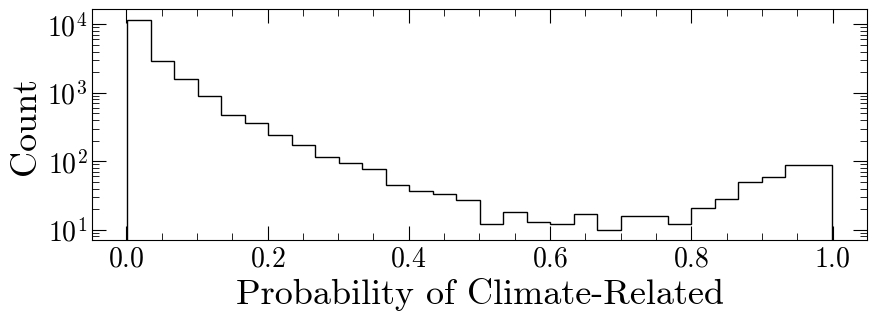

In [23]:
plt.figure(figsize=(10,3))
plt.hist(data['probability_score'], color = 'k', histtype='step', bins=30)
plt.xlabel('Probability of Climate-Related')
plt.ylabel('Count')
plt.yscale('log')

In [24]:
climate_mask = np.all([data['probability_score'] > 0.5], axis=0)
print(f'no. climate-related: {len(data[climate_mask])}')

no. climate-related: 458


## Classifications from GPT

In [25]:
with open('gpt_responses.pkl', 'rb') as f:
    parameters = pickle.load(f)

In [29]:
# analyze all the times that GPT returned non-standard answers
fails = {}
for key, speech in parameters.items():
    fails[key] = []
    for ii, response in enumerate(speech):
        response[0] = response[0].lower()
        response[0] = re.sub(r'[^\w\s]', '', response[0])
        if response[0] not in ['yes', 'no' ]:
            fails[key].append([ii, response[0]])
fails = {key: value for key, value in fails.items() if value != []}
print(f"Failure rate: {len(fails) / len(parameters)*10:2.2f}%")

Failure rate: 0.20%


In [13]:
# Clean the malformatted answers out
for key, index_list in fails.items():
    if key in parameters:
        # Retrieve indices from dict1 for the current key
        indices_to_delete = {item[0] for item in index_list}
        # Filter out elements in dict2[key] whose index is not in indices_to_delete
        parameters[key] = [item for i, item in enumerate(parameters[key]) if i not in indices_to_delete]

In [14]:
classifier = {'yes' : 1, 'no' : 0}

keys, class_max, class_avg, summs, lengths = [], [], [], [], []
for key, item in parameters.items():
    vals = np.array(item)[:,0]
    number_vals = [classifier[val] for val in vals]

    maximum = np.max(number_vals)
    summ = sum(number_vals)
    length = len(number_vals)

    keys.append(key)
    class_max.append(maximum)
    class_avg.append(summ / length)
    summs.append(summ)
    lengths.append(length)
classification = pd.DataFrame({
    'id' : keys,
    'gpt_maximum_classification' : class_max,
    'gpt_average_classification' : class_avg,
    'gpt_sum' : summs,
    'gpt_length' : lengths
})
classification.to_csv('classifications.csv')

In [15]:
full_data = pd.merge(data, classification, on="id")

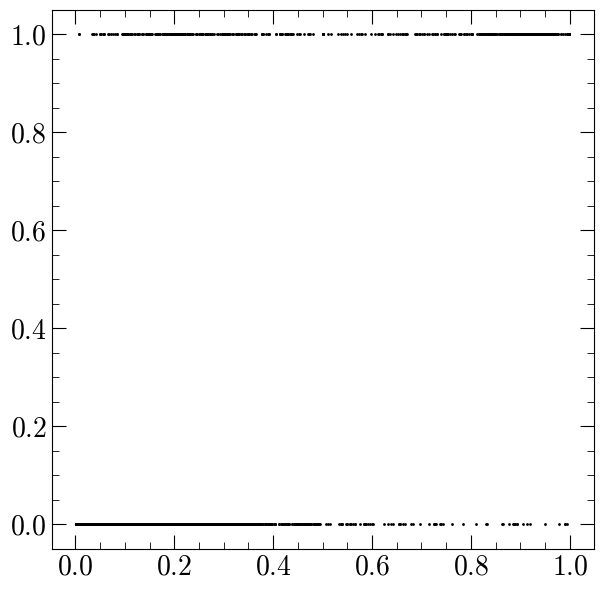

In [39]:
plt.scatter(full_data.probability_score, full_data.gpt_maximum_classification, c = 'k', s = 1)

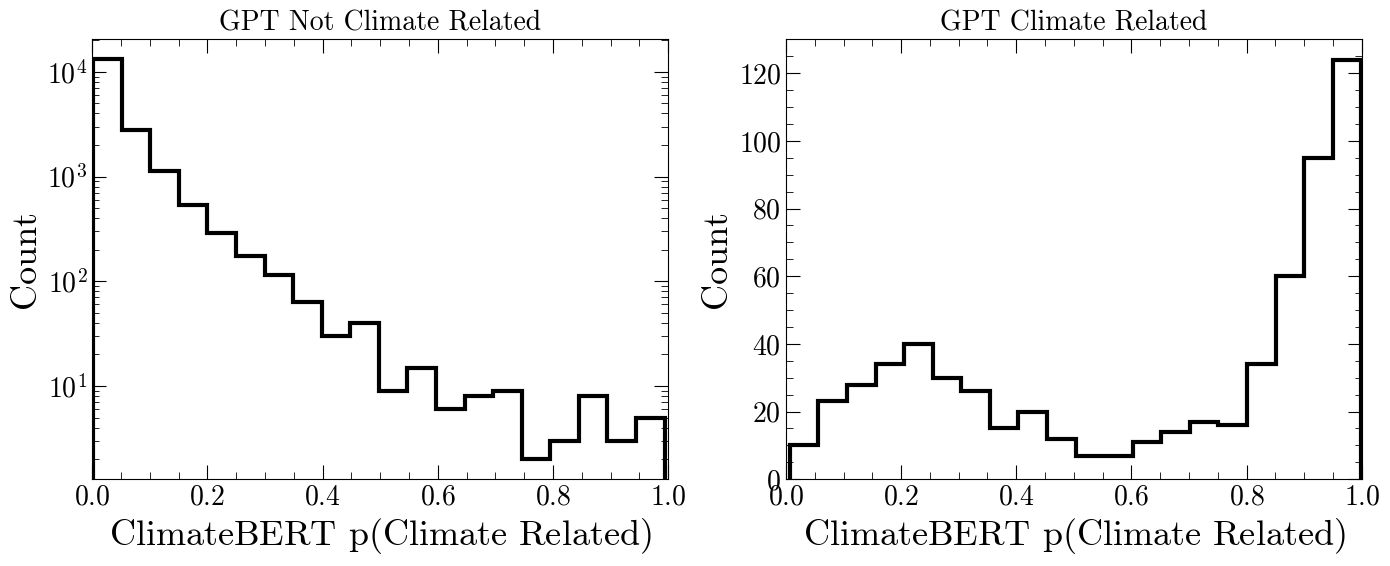

In [53]:
gpt_yes = full_data.query("gpt_maximum_classification == 1")
gpt_no = full_data.query("gpt_maximum_classification == 0")

fig, ax = plt.subplots(ncols = 2, figsize=(14, 6))

ax[0].hist(gpt_no.probability_score, bins=20, color='k', histtype='step', linewidth=3, label = 'GPT No')
ax[0].set_title("GPT Not Climate Related", fontsize=20)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'ClimateBERT $p(\text{Climate Related})$')
ax[0].set_ylabel('Count')
ax[0].set_xlim(0,1)



# Plot histograms in each subplot
ax[1].hist(gpt_yes.probability_score, bins=20, color='k', histtype='step', linewidth=3, label="GPT Yes")
ax[1].set_title("GPT Climate Related", fontsize=20)
ax[1].set_xlabel(r'ClimateBERT $p(\text{Climate Related})$')
ax[1].set_ylabel('Count')
ax[1].set_xlim(0,1)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig.savefig('histogram.pdf')

In [18]:
bert_no_gpt_yes = gpt_yes.query("probability_score < 0.5")
bert_no_gpt_yes.to_csv("../data/bert_no_gpt_yes.csv")

bert_yes_gpt_no = gpt_no.query("probability_score > 0.5")
bert_yes_gpt_no.to_csv("../data/bert_yes_gpt_no.csv")